# Sharded Sinkhorn

In [1]:
# Misc.
import functools
import time
from typing import Optional

# Jax and sharding utils
import jax
import jax.numpy as jnp
from jax.experimental import mesh_utils

import matplotlib.pyplot as plt

# Ott
from ott.data import get_cifar10
from ott.geometry import costs, pointcloud
from ott.math import utils
from ott.solvers import linear
from ott.solvers.linear import sinkhorn

We show in this notebook how calls the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solver can be scaled to handle a hundred thousand points (and possibly more) in dimension `3k` using data sharding across multiple GPUs. We start by loading the `CIFAR-10` train fold, originally of size `50k`, duplicated using horizontal flips.

In [2]:
x, y, label = get_cifar10(
    sigma=1.0, gaussian_blur_kernel_size=15, use_flip=True
)

This loads two point-clouds in dimension `3072` of `100k` points each.

In [3]:
x.shape, y.shape

((100000, 3072), (100000, 3072))

The source `x` contains all images. The target `y` contains the same images, to which a Gaussian blur has been applied. This blurring operation is an optimal transport: as shown in {cite}`kassraie:24`, an optimal transport solver parameterized with a squared-Euclidean cost should match `x` to `y` exactly in that order. In other words, the optimal transport matrix should be the identity divided by `100k`, each image is optimally matched to its blurred counterpart.

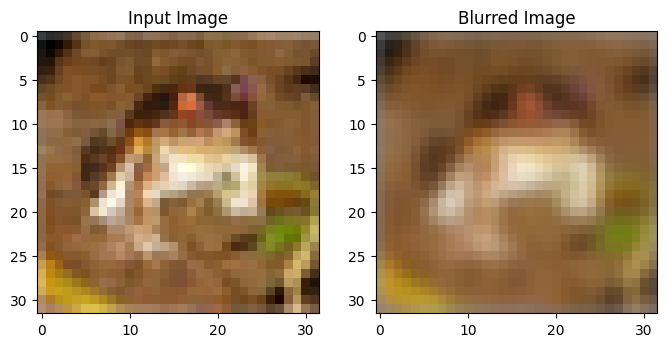

In [4]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0].reshape((3, 32, 32)).transpose(1, 2, 0) / 2 + 0.5)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(y[0].reshape((3, 32, 32)).transpose(1, 2, 0) / 2 + 0.5)
plt.show()

We run this notebook on a node of 8 GPUs (`A100`), as is revealed in this call.

In [5]:
jax.devices()

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

We introduce a simple convenience wrapper designed to shard the input point clouds `x` and `y` across 8 GPUs. A more advanced sharding across multiple nodes can be carried out if necessary.

In [6]:
from jax.sharding import Mesh, NamedSharding
from jax.sharding import PartitionSpec as P


def shard_samples(x: jnp.ndarray) -> tuple[jnp.ndarray, NamedSharding]:
    num_devices = jax.device_count()
    devices = mesh_utils.create_device_mesh((num_devices,))
    mesh = Mesh(devices, axis_names=("batch",))
    sharding = NamedSharding(mesh, P("batch", None))

    return jax.device_put(x, sharding), sharding

The inputs are both sharded, and we store that sharding information.

In [7]:
x_sharded, _ = shard_samples(x)
y_sharded, sharding = shard_samples(y)

The `run` function is a wrapper around a {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solver. The `batch_size` parameter is unchanged, and set to `None` by default. This means that the full `100k x 100k` cost matrix will be materialized, and stored in blocks across multiple GPUs. If that `batch_size` argument is set to an integer, the cost matrix would be re-instantiated at each iteration, using blocks of `100k x batch_size`. Although the code below would still be able to run in the default setting, we advocate using a large batch size in practice.

Note that we use the {class}`~ott.geometry.costs.NegDotProduct` cost function to obtain better efficiency, as outlined in {cite}`klein:25b`.

In [8]:
# x, y, epsilon
in_shardings = (sharding, sharding, None)


@functools.partial(
    jax.jit, static_argnames=("batch_size",), in_shardings=in_shardings
)
def run(
    x: jnp.ndarray,
    y: jnp.ndarray,
    epsilon: Optional[float] = None,
    batch_size: Optional[int] = None,
) -> sinkhorn.SinkhornOutput:
    geom = pointcloud.PointCloud(
        x,
        y,
        cost_fn=costs.NegDotProduct(),
        batch_size=batch_size,
        epsilon=epsilon,
        relative_epsilon="std",  # Epsilon is passed as a multiplier for the std of the cost matrix.
    )
    return linear.solve(geom)

Since the expected optimal coupling should be `I_n/n`, we simply compute to what extent the output of the Sinkhorn algorithm resembles that matrix. We extract its diagonal and compute its sum (should be close to 1 when using a small `epsilon`), or alternatively its generalized KL to `1_n/n`. We carry out that computation over a grid of 10 `epsilon` values.

In [9]:
n = x.shape[0]
kls = []
sums = []
times = []
norm_ents = []
num_iters = []
epsilons = 10 ** jnp.linspace(-1.5, 0, 6)
# Run the Sinkhorn solver with different epsilon values
for epsilon in epsilons:
    start = time.time()
    out = run(x_sharded, y_sharded, epsilon, 25_000)
    assert (
        out.converged
    ), f"Sinkhorn did not converge in {out.n_iters} iterations"
    times.append(time.time() - start)
    diag = out.diag
    kls.append(utils.gen_kl(jnp.ones((n,)) / n, diag))
    sums.append(jnp.sum(diag))
    num_iters.append(out.n_iters)
    norm_ents.append(out.normalized_entropy)

These results are summarized in plots below, displaying also running time, number of iterations and normalized entropy (as presented  as a function of `epsilon`.

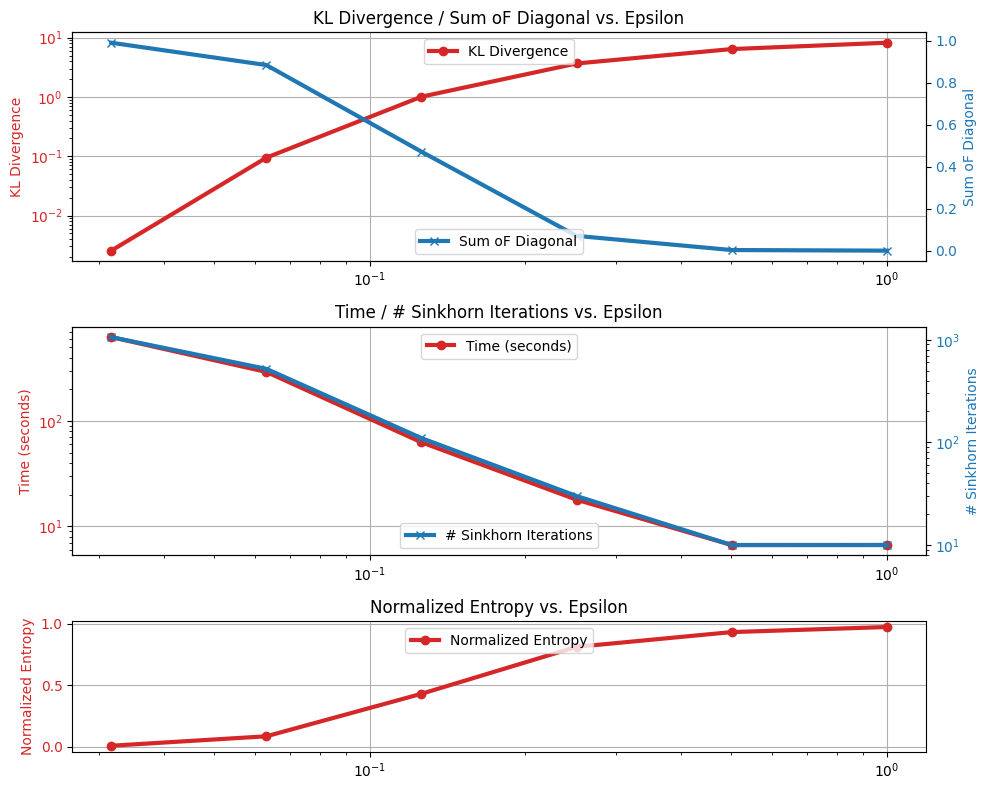

In [41]:
plt.figure(figsize=(10, 8))
ax_met = plt.subplot2grid((8, 1), (0, 0), rowspan=3)
ax_times = plt.subplot2grid((8, 1), (3, 0), rowspan=3)
ax_norment = plt.subplot2grid((8, 1), (6, 0), rowspan=2)


def plot_two_y(ax, x, y1, y2, label1, label2, log1, log2, title):
    color = "tab:red"
    ax.plot(x, y1, color=color, marker="o", linewidth=3, label=label1)
    ax.set_ylabel(label1, color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xscale("log")
    if log1:
        ax.set_yscale("log")
    ax.set_title(title)
    ax.legend(loc="upper center")
    ax.grid(True)

    if y2 is not None:
        color = "tab:blue"
        ax2 = ax.twinx()
        ax2.set_ylabel(label2, color=color)
        ax2.plot(
            epsilons, y2, color=color, marker="x", linewidth=3, label=label2
        )
        ax2.legend(loc="lower center")
        ax2.tick_params(axis="y", labelcolor=color)
        if log2:
            ax2.set_yscale("log")


plot_two_y(
    ax_met,
    epsilons,
    kls,
    sums,
    "KL Divergence",
    "Sum oF Diagonal",
    True,
    False,
    "KL Divergence / Sum oF Diagonal vs. Epsilon",
)
plot_two_y(
    ax_times,
    epsilons,
    times,
    num_iters,
    "Time (seconds)",
    "# Sinkhorn Iterations",
    True,
    True,
    "Time / # Sinkhorn Iterations vs. Epsilon",
)
plot_two_y(
    ax_norment,
    epsilons,
    norm_ents,
    None,
    "Normalized Entropy",
    None,
    False,
    True,
    "Normalized Entropy vs. Epsilon",
)

plt.tight_layout()